In [280]:
# %load_ext autoreload
# %autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import numpy as np
from amwag.app_utilities.preprocessing import *
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import Holt

from sklearn import set_config
set_config(transform_output="pandas")

RSEED = 5

In [281]:
df = pd.read_csv("../data/AQUASTAT_complete.csv", index_col=0)

pre-split preprocessing

In [282]:
pre_split_processor = get_pre_split_processor()

In [283]:
df_pre = pre_split_processor.transform(df)
df_pre.shape

(8575, 41)

limit years here!

In [284]:
df_pre = df_pre.query("year > 2000")

In [285]:
targets = ['gdp_per_capita', 'water_stress', 'total_population_with_access_to_safe_drinking_water']
df_targets = df_pre[["country", "year"] + targets]
df_targets.isna().sum()

country                                                 0
year                                                    0
gdp_per_capita                                          0
water_stress                                           69
total_population_with_access_to_safe_drinking_water     0
dtype: int64

In [333]:
df_targets.groupby("country").apply(lambda group: group.fillna(method="bfill")).isna().sum() # only early years are missing in water_stress

country                                                0
year                                                   0
gdp_per_capita                                         0
water_stress                                           0
total_population_with_access_to_safe_drinking_water    0
dtype: int64

In [335]:
df_targets.to_csv("../data/targets_over_years.csv")

In [286]:
df_pre.drop(columns=targets).to_csv("../data/features_over_years.csv")

In [287]:
df_ts = df_pre.sort_values("year").set_index("year")

In [288]:
#df_ts.index = pd.to_datetime(df_ts.index, format="%Y")

In [323]:
df_ts

,country,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2001,Afghanistan,44.702708,100.000000,11.875440,20.000000,30.613807,98.518576,54.063068,7753.0000,92.979179,...,47.150,2182.164400,21606.988,32.0,10.650,3023.558860,20.300740,939.545114,4648.139,18.18
2001,Belgium,NaN,100.000000,28.358991,0.037200,0.203279,0.521242,1.109350,865.8000,13.983887,...,12.000,1162.901241,10319.019,100.0,0.900,1773.424392,7.136800,691.616131,10028.603,6.30
2001,Mauritius,NaN,100.000000,46.568627,0.467840,17.006184,72.160428,5.887679,95.0000,56.427708,...,2.751,2304.180274,1193.917,99.3,0.893,2304.180274,0.648333,543.030490,508.114,0.00
2001,Mauritania,24.845746,52.400577,0.448239,1.430750,12.550439,93.078099,24.868960,462.0000,185.020722,...,0.400,148.016578,2702.400,43.3,0.300,4218.472469,1.537150,568.809207,1077.677,11.00
2001,United Kingdom of Great Britain and Northern I...,NaN,100.000000,23.406264,1.833000,1.246939,12.079873,0.782121,5702.0000,89.159636,...,145.000,2452.460823,59124.288,100.0,9.800,2486.287869,15.174000,256.645797,46580.884,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,Guatemala,24.809144,100.000000,18.780421,1.886000,1.474474,56.737162,10.243420,2045.0000,25.890338,...,109.200,6095.257488,17915.568,92.8,33.700,7139.600598,3.324100,185.542540,9284.293,18.71
2020,Greece,43.051419,100.000000,24.402547,8.107000,11.852339,80.092867,4.230805,3220.1601,1182.187102,...,58.000,5564.587884,10423.054,100.0,10.300,6562.376056,10.122000,971.116527,8850.409,10.40
2020,Philippines,34.760355,94.812910,37.250000,67.830825,14.160924,78.995084,10.184808,11175.0000,64.837836,...,479.000,4371.192625,109581.078,91.8,180.000,4371.192625,85.867147,783.594655,52008.603,0.00


In [329]:
df_imp = df_ts.groupby("country").apply(lambda group: group.interpolate())
df_imp = df_imp.groupby("country").apply(lambda group: group.fillna(method="ffill"))

In [330]:
df_imp.isna().sum().sum()

2151

In [209]:
for c in df_ts.country.unique():
    df_1 = df_ts.query("country == @c")
    if df_1.isna().sum().sum() > 10:
        print(c)

Mauritius
United Kingdom of Great Britain and Northern Ireland
Malta
Luxembourg
Lithuania
Bhutan
Latvia
Lao People's Democratic Republic
Kuwait
Jordan
Philippines
Peru
Azerbaijan
Paraguay
Panama
Palestine
Bahrain
Oman
North Macedonia
Bangladesh
Barbados
United Arab Emirates
Nepal
Belarus
Norway
Puerto Rico
Ethiopia
Canada
Egypt
Central African Republic
Yemen
Chad
Chile
Croatia
Costa Rica
Comoros
Democratic People's Republic of Korea
Finland
Israel
Iraq
Indonesia
Iceland
Honduras
Guyana
Burundi
Germany
Gambia
Cambodia
Qatar
Switzerland
Australia
Turkmenistan
Rwanda
Thailand
Sri Lanka
Republic of Korea
Slovenia
Timor-Leste
Saudi Arabia
South Sudan


In [210]:
df_1 = df_ts.query("country == 'Chad'")
df_1.isna().sum().sum()

40

In [211]:
df_int = df_1.drop("country", axis=1).interpolate(axis=1)
df_int.isna().sum().sum()

0

In [212]:
df_int.head()

,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,dependency_ratio,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2001,0.958824,16.910839,3.060748,0.637253,1.394427,77.682243,36.605330,3930.0,1998.588621,67.177243,...,15.0,1728.498715,8678.051,45.2,11.5,5266.159418,0.820333,94.529674,1877.232,30.7
2002,0.990247,17.135515,2.904984,0.672200,1.470897,78.039380,34.445495,3730.0,1898.588621,67.177243,...,15.0,1663.112595,9019.233,45.7,11.5,5066.949706,0.861360,95.502578,1953.584,30.7
2003,0.990247,17.135515,2.982866,0.672200,1.470897,77.492391,40.159436,3830.0,1948.588621,67.177243,...,15.0,1600.185024,9373.916,46.2,11.5,4875.230373,0.867440,92.537633,2032.953,30.7
2004,0.990247,17.135515,2.982866,0.672200,1.470897,76.953018,28.339881,3830.0,1948.588621,67.177243,...,15.0,1540.868929,9734.767,46.7,11.5,4694.514003,0.873520,89.731988,2113.721,30.7
2005,0.990247,17.135515,3.060748,0.672200,1.470897,76.421101,25.757433,3930.0,1998.588621,67.177243,...,15.0,1485.643778,10096.633,47.2,11.5,4526.261378,0.879600,87.118151,2194.746,30.7


modeling

In [213]:
def fit_variable(train_var):
    holt_winters = Holt(train_var)
    return holt_winters.fit()

def predict_variable(model, pred_time):
    return model.forecast(pred_time[1] - pred_time[0] + 1)

def get_const_columns(df):
    unique_values = df.nunique()
    constant_columns = unique_values[unique_values == 1].index.tolist()
    return constant_columns

In [214]:
pd.to_datetime(train.index, format="%Y")

DatetimeIndex(['2001-01-01', '2002-01-01', '2003-01-01', '2004-01-01',
               '2005-01-01', '2006-01-01', '2007-01-01', '2008-01-01',
               '2009-01-01', '2010-01-01', '2011-01-01', '2012-01-01',
               '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01',
               '2017-01-01'],
              dtype='datetime64[ns]', name='year', freq=None)

In [215]:
#creating the train and validation set
train = df_int.query("index < 2018")
valid = df_int.query("index >= 2018")

In [216]:
train.index = pd.to_datetime(train.index, format="%Y")
valid.index = pd.to_datetime(valid.index, format="%Y")

# const_cols = get_const_columns(train)
# train = train.drop(columns=const_cols)
# valid = valid.drop(columns=const_cols)

In [217]:
prediction_time_frame = (2018, 2020)
model_dict = {}
pred_df = pd.DataFrame({"year": np.arange(prediction_time_frame[0], prediction_time_frame[1]+1, 1)})
pred_df.set_index("year", inplace=True)
pred_df.index = pd.to_datetime(pred_df.index, format="%Y")

for var in train.columns.tolist():

    # fit model and get prediction
    var_model = fit_variable(train[var])
    var_pred = predict_variable(var_model, prediction_time_frame)

    # write results into dictionaries
    model_dict[var] = var_model
    pred_df[var] = var_pred.values

In [218]:
valid

,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,dependency_ratio,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.990247,17.135515,4.079439,0.6722,1.470897,76.421101,32.442121,5238.0,2652.588621,67.177243,...,15.0,969.134425,15477.729,50.8,11.5,2952.629549,0.8796,56.830043,3540.279,30.7
2019-01-01,0.990247,17.135515,4.079439,0.6722,1.470897,76.421101,31.123508,5238.0,2652.588621,67.177243,...,15.0,940.623104,15946.876,50.8,11.5,2865.765056,0.8796,55.158139,3681.488,30.7
2020-01-01,0.990247,17.135515,4.079439,0.6722,1.470897,76.421101,31.436945,5238.0,2652.588621,67.177243,...,15.0,913.193973,16425.864,50.8,11.5,2782.197637,0.8796,53.549695,3830.260,30.7


In [219]:
pred_df

,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,dam_capacity_per_capita,dependency_ratio,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
year,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.990247,17.135516,4.071154,0.672200,1.470897,76.421101,35.664665,5227.362395,2647.269819,67.177243,...,15.0,962.831527,15455.098247,50.803744,11.5,2933.426998,0.879598,56.720689,3527.846600,30.7
2019-01-01,0.990248,17.135519,4.063350,0.672200,1.470898,76.421100,37.487027,5217.342972,2642.260108,67.177243,...,15.0,927.587100,15893.774713,50.807487,11.5,2826.049265,0.879596,54.879925,3650.403279,30.7
2020-01-01,0.990248,17.135522,4.055546,0.672201,1.470900,76.421100,39.309389,5207.323550,2637.250397,67.177243,...,15.0,892.342673,16332.451180,50.811231,11.5,2718.671532,0.879594,53.039161,3772.959958,30.7


In [220]:
cols = train.columns.tolist()
#check rmse
for e, i in enumerate(cols):
    # print(e, i)
    # display(pred[i])
    print('rmse value for', i, 'is : ', np.sqrt(mean_squared_error(pred_df[i], valid[i])))

rmse value for %_of_agricultural_gva_produced_by_irrigated_agriculture is :  4.7667737519787824e-07
rmse value for %_of_agricultural_water_managed_area_equipped_for_irrigation is :  4.661740366841497e-06
rmse value for %_of_total_country_area_cultivated is :  0.017304895396799764
rmse value for agricultural_water_withdrawal is :  5.301269759614962e-07
rmse value for agricultural_water_withdrawal_as_%_of_total_renewable_water_resources is :  1.5840723087632507e-06
rmse value for agricultural_water_withdrawal_as_%_of_total_water_withdrawal is :  7.348654416279405e-09
rmse value for agriculture_value_added_%_gdp is :  6.133366446256293
rmse value for cultivated_area_arable_land_plus_permanent_crops is :  22.217981232647038
rmse value for dam_capacity_per_capita is :  11.108989935638496
rmse value for dependency_ratio is :  0.0
rmse value for gdp_per_capita is :  137.40036926381498
rmse value for groundwater_accounted_inflow is :  0.0
rmse value for groundwater_entering_the_country_total i

In [221]:
train.shape

(17, 39)

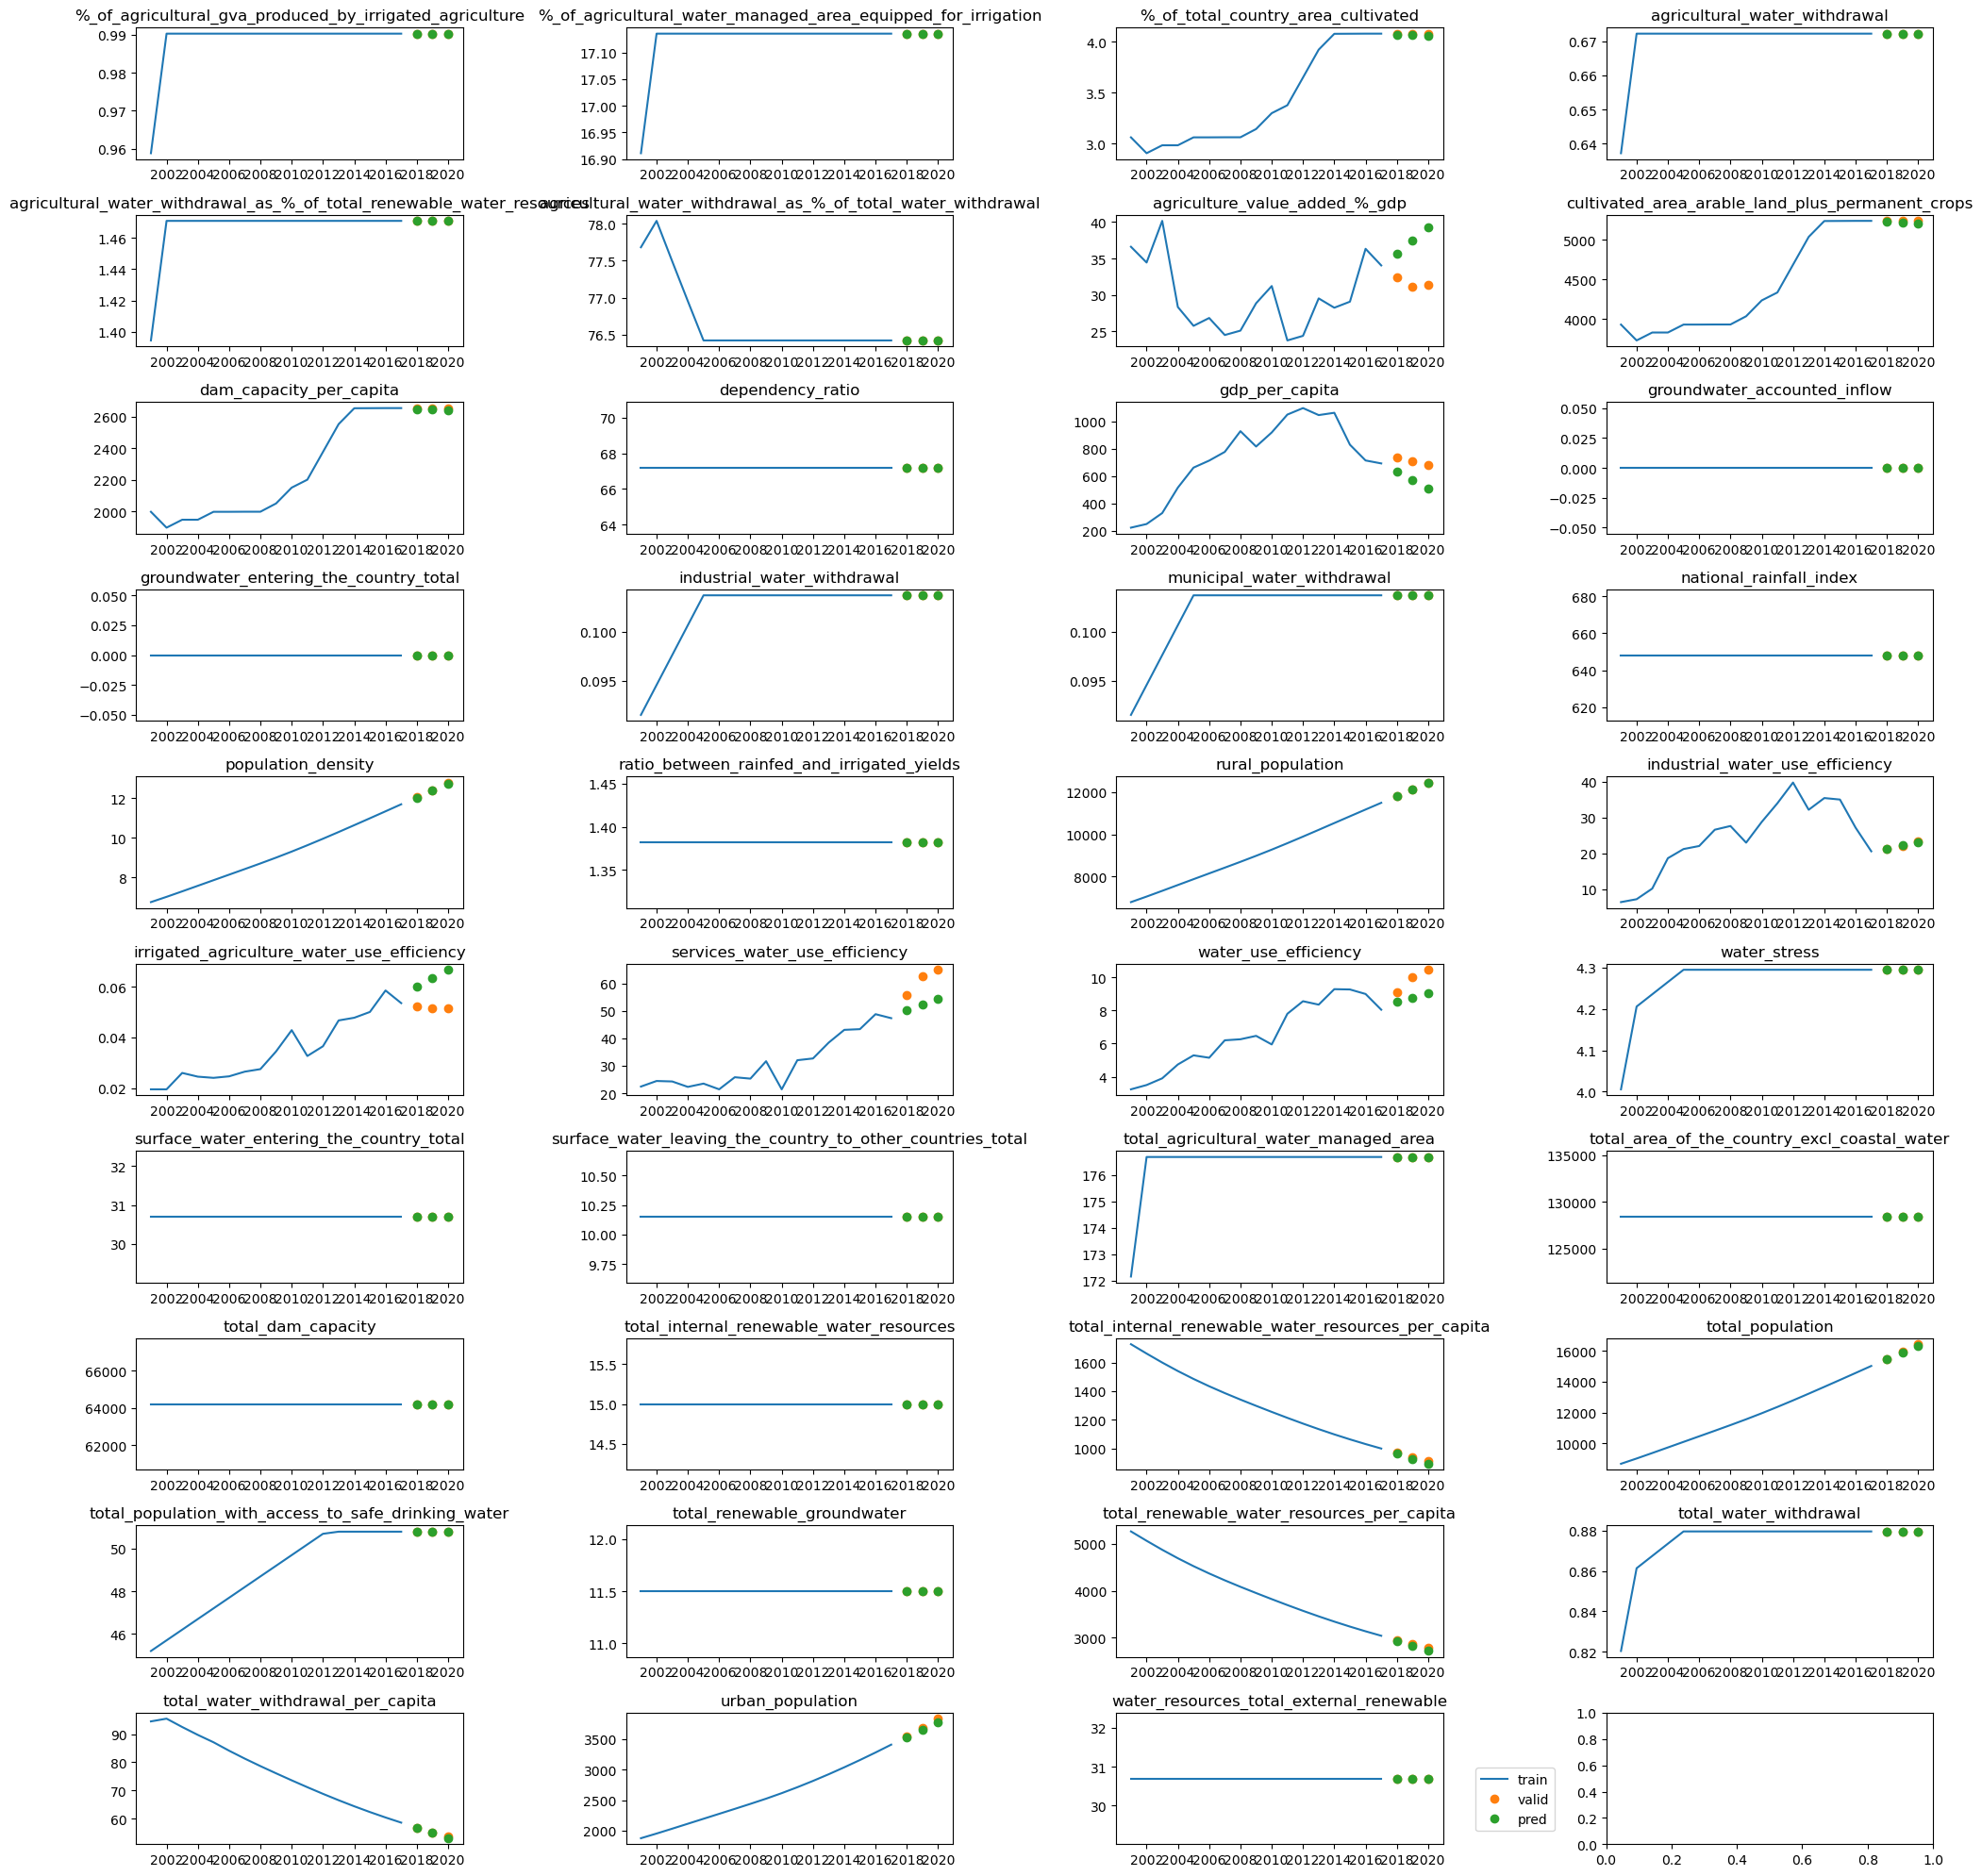

In [222]:
fig, axs = plt.subplots(10, 4, figsize=(20,20))
cols = valid.columns.tolist()

for i, ax in enumerate(axs.flat):
    if i<=train.shape[1]-1:
        ax.plot(train[cols[i]], label="train")
        ax.plot(valid[cols[i]], 'o', label="valid")
        ax.plot(pred_df[cols[i]], 'o', label="pred")
        ax.set_title(cols[i])
    if i==train.shape[1]-1:
        ax.legend(loc=(1.1, 0.1))
fig.tight_layout()

training for app

In [223]:
def fit_country(df):
    vars_dict = {}
    for var in train.columns.tolist():
        vars_dict[var] = fit_variable(df[var])
    return vars_dict

In [224]:
import warnings
warnings.filterwarnings("ignore")

In [225]:
forecast_models_dict = {}

for c in df_ts.country.unique():
    df_c = df_ts.query("country == @c")
    df_c = df_c.drop("country", axis=1).interpolate(axis=1)
    df_c = df_c.fillna(method='bfill')
    forecast_models_dict[c] = fit_country(df_c)

In [226]:
with open("../ts_forecast_models.pkl", "wb") as file:
    pkl.dump(forecast_models_dict, file)

In [227]:
import cProfile, pstats, io


def profile(fnc):
    
    """A decorator that uses cProfile to profile a function. 
       Starts the profile before executing a function, then exeuctes the function,
       then stops the profile, then prints out a diagnostics report.
       
       Lots of boilerplate code from the Python 3 documentation:
       https://docs.python.org/3/library/profile.html#profile.Profile
       """
    
    def inner(*args, **kwargs):
        
        pr = cProfile.Profile()
        pr.enable() ### start the profiler
        
        retval = fnc(*args, **kwargs) ### then actually execute the function
        
        pr.disable() ### then we stop the profiler
        
        ###then print the results to the standard output
        s = io.StringIO()
        sortby = 'cumulative'
        ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
        ps.print_stats()
        print(s.getvalue())
        
        ### then return the actual return value of the inner function we executed
        return retval

    ### execute the innter function
    return inner

In [228]:
used_columns = ['country', 'year',
       '%_of_agricultural_gva_produced_by_irrigated_agriculture',
       '%_of_agricultural_water_managed_area_equipped_for_irrigation',
       '%_of_total_country_area_cultivated', 'agricultural_water_withdrawal',
       'agricultural_water_withdrawal_as_%_of_total_renewable_water_resources',
       'agricultural_water_withdrawal_as_%_of_total_water_withdrawal',
       'agriculture_value_added_%_gdp',
       'cultivated_area_arable_land_plus_permanent_crops',
       'dam_capacity_per_capita', 'dependency_ratio', 'gdp_per_capita',
       'groundwater_accounted_inflow',
       'groundwater_entering_the_country_total', 'industrial_water_withdrawal',
       'municipal_water_withdrawal', 'national_rainfall_index',
       'population_density', 'ratio_between_rainfed_and_irrigated_yields',
       'rural_population', 'industrial_water_use_efficiency',
       'irrigated_agriculture_water_use_efficiency',
       'services_water_use_efficiency', 'water_use_efficiency', 'water_stress',
       'surface_water_entering_the_country_total',
       'surface_water_leaving_the_country_to_other_countries_total',
       'total_agricultural_water_managed_area',
       'total_area_of_the_country_excl_coastal_water', 'total_dam_capacity',
       'total_internal_renewable_water_resources',
       'total_internal_renewable_water_resources_per_capita',
       'total_population',
       'total_population_with_access_to_safe_drinking_water',
       'total_renewable_groundwater',
       'total_renewable_water_resources_per_capita', 'total_water_withdrawal',
       'total_water_withdrawal_per_capita', 'urban_population',
       'water_resources_total_external_renewable']

In [229]:
@profile
def forecast_dataset(model_dict, used_columns, n_years):
    df = pd.DataFrame(columns=used_columns)
    for i, (c, vm_dict) in enumerate(model_dict.items()):
        #print(c, vm_dict)
        c_forecasts = {v: m.forecast(n_years) for v, m in vm_dict.items()}

        df_c = pd.DataFrame(c_forecasts)

        df_c.insert(0, "year", [2020 + n+1 for n in range(n_years)])
        df_c.insert(0, "country", [c]*n_years)
        df = pd.concat([df, df_c])

        #display(df_c)
        #if i == 3:  break

    #df.reset_index(inplace=True)
    return df


In [230]:
fc = forecast_dataset(forecast_models_dict, used_columns, 5)

         10293257 function calls (10154973 primitive calls) in 10.784 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.017    0.017   10.784   10.784 C:\Users\soa\AppData\Local\Temp\ipykernel_4924\1268391950.py:1(forecast_dataset)
      163    0.015    0.000   10.042    0.062 C:\Users\soa\AppData\Local\Temp\ipykernel_4924\1268391950.py:6(<dictcomp>)
     6357    0.026    0.000   10.012    0.002 c:\Users\soa\anaconda3\lib\site-packages\statsmodels\base\wrapper.py:106(wrapper)
     6357    0.057    0.000    9.341    0.001 c:\Users\soa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\results.py:253(forecast)
     6357    0.049    0.000    9.267    0.001 c:\Users\soa\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:478(predict)
12714/6357    0.048    0.000    8.538    0.001 c:\Users\soa\anaconda3\lib\site-packages\pandas\util\_decorators.py:166(wrapper)
     6357    1.321    0.000    8.487

In [231]:
fc.isna().sum()

country                                                                  0
year                                                                     0
%_of_agricultural_gva_produced_by_irrigated_agriculture                  0
%_of_agricultural_water_managed_area_equipped_for_irrigation             0
%_of_total_country_area_cultivated                                       0
agricultural_water_withdrawal                                            0
agricultural_water_withdrawal_as_%_of_total_renewable_water_resources    0
agricultural_water_withdrawal_as_%_of_total_water_withdrawal             0
agriculture_value_added_%_gdp                                            0
cultivated_area_arable_land_plus_permanent_crops                         0
dam_capacity_per_capita                                                  0
dependency_ratio                                                         0
gdp_per_capita                                                           0
groundwater_accounted_inf

In [232]:
fc[["country","%_of_agricultural_gva_produced_by_irrigated_agriculture", "%_of_agricultural_water_managed_area_equipped_for_irrigation"]].loc[fc["%_of_agricultural_gva_produced_by_irrigated_agriculture"].isnull()]["country"].unique()

array([], dtype=object)

In [233]:
df_ts.query("country == 'Belgium'")["%_of_agricultural_gva_produced_by_irrigated_agriculture"].to_frame().fillna(method='bfill')

,%_of_agricultural_gva_produced_by_irrigated_agriculture
year,
2001,0.383530
2002,0.383530
2003,0.383530
2004,0.538595
2005,0.693450
2006,0.931192
2007,1.168439
2008,1.165252
2009,1.039938


In [234]:
fc

,country,year,%_of_agricultural_gva_produced_by_irrigated_agriculture,%_of_agricultural_water_managed_area_equipped_for_irrigation,%_of_total_country_area_cultivated,agricultural_water_withdrawal,agricultural_water_withdrawal_as_%_of_total_renewable_water_resources,agricultural_water_withdrawal_as_%_of_total_water_withdrawal,agriculture_value_added_%_gdp,cultivated_area_arable_land_plus_permanent_crops,...,total_internal_renewable_water_resources,total_internal_renewable_water_resources_per_capita,total_population,total_population_with_access_to_safe_drinking_water,total_renewable_groundwater,total_renewable_water_resources_per_capita,total_water_withdrawal,total_water_withdrawal_per_capita,urban_population,water_resources_total_external_renewable
20,Afghanistan,2021,44.310084,100.0,12.411893,20.00,30.613807,98.169627,27.224019,8103.349625,...,47.15,1178.891179,39846.888783,55.302211,10.65,1633.445621,20.372900,509.343151,10210.484331,18.18
21,Afghanistan,2022,44.291388,100.0,12.432876,20.00,30.613807,98.169626,28.356569,8117.115028,...,47.15,1146.655430,40765.259099,55.304245,10.65,1588.780486,20.372900,495.377585,10516.631663,18.18
22,Afghanistan,2023,44.272691,100.0,12.453858,20.00,30.613807,98.169626,29.489118,8130.880430,...,47.15,1114.419681,41683.629415,55.306279,10.65,1544.115351,20.372900,481.412019,10822.778995,18.18
23,Afghanistan,2024,44.253995,100.0,12.474841,20.00,30.613807,98.169625,30.621668,8144.645833,...,47.15,1082.183932,42601.999732,55.308313,10.65,1499.450216,20.372900,467.446453,11128.926327,18.18
24,Afghanistan,2025,44.235299,100.0,12.495823,20.00,30.613807,98.169624,31.754218,8158.411235,...,47.15,1049.948183,43520.370048,55.310347,10.65,1454.785082,20.372901,453.480887,11435.073659,18.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,Sudan,2021,22.911621,100.0,11.294377,25.91,68.544974,96.194542,19.402164,21209.383808,...,4.00,88.826512,44727.211817,55.500000,3.00,839.410498,26.935000,598.135500,15804.514420,33.80
10,Sudan,2022,22.911621,100.0,11.294377,25.91,68.544974,96.194542,17.919491,21207.904786,...,4.00,86.447696,45605.953453,55.500000,3.00,816.930662,26.935000,582.117132,16259.604841,33.80
11,Sudan,2023,22.911621,100.0,11.294377,25.91,68.544974,96.194542,16.436819,21206.425764,...,4.00,84.068881,46484.695089,55.500000,3.00,794.450826,26.935000,566.098765,16714.695262,33.80
12,Sudan,2024,22.911621,100.0,11.294377,25.91,68.544974,96.194542,14.954146,21204.946743,...,4.00,81.690065,47363.436725,55.500000,3.00,771.970990,26.935000,550.080397,17169.785683,33.80


In [235]:
fc_targets = fc[["country", "year"] + targets]
fc_targets.head(5)

,country,year,gdp_per_capita,water_stress,total_population_with_access_to_safe_drinking_water
20,Afghanistan,2021,516.457005,54.757019,55.302211
21,Afghanistan,2022,524.460288,54.757019,55.304245
22,Afghanistan,2023,532.463570,54.757019,55.306279
23,Afghanistan,2024,540.466853,54.757019,55.308313
24,Afghanistan,2025,548.470136,54.757019,55.310347


In [236]:
#fc = fc.drop(columns=targets)

In [239]:
# with open("forecast_2021_2025.pkl", "wb") as file:
#     pkl.dump(fc, file)
# with open("forecast_2021_2025_targets.pkl", "wb") as file:
#     pkl.dump(fc_targets, file)

fc.to_csv("../data/forecast_2021_2025.csv")
fc_targets.to_csv("forecast_2021_2025_targets.csv")

In [238]:
fc.isna().sum().sum()

0